# 1 Portfolio selection using Random Forest

##### Goal: Develop and train a predictive model that can reliably predict future changes in the stock prices, and then use it for construction of stock portfolio.  The objective is to 'beat the market'. <br>
Data: stocks obtained from Wikipedia by scrapping. Stock prices and fundamentals are obtained using API 'yahoofinancials' (https://pypi.org/project/yahoofinancials/). S&P100 index and stock constituents are considered. Planned expansion - to S&P500, and then to Russell 3000 stocks. <br>
Training is performed using 65% of stocks data. Testing (and back-testing) performed for the remaining 35% of the time period. 

 ++++++++++++++++++++++++++++++++++++++++++++ <br>
 By: Yuriy Podvysotskiy <br>
 Date: November 4, 2019 <br>
 ++++++++++++++++++++++++++++++++++++++++++++

In [25]:
# Import packages:
import pandas as pd
import numpy as np
import yahoofinancials as yf
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings("ignore")


In [8]:
# Scrap stocks names in S&P 100 index:
url = 'https://en.wikipedia.org/wiki/S%26P_100'
textnames = requests.get(url)

soup = BeautifulSoup(textnames.text, 'lxml')
tables = soup.select('table')
tables_data = tables[2].select('tr')

col_names = ["Ticker", "Name"]
stocks = pd.DataFrame(columns=col_names)

for i in range(1, len(tables_data)):
    a1 = tables_data[i].select('td')[0].getText().replace("\n","")
    a2 = tables_data[i].select('td')[1].getText().replace("\n","")
    
    stocks = stocks.append(pd.DataFrame([[a1, a2]], columns = col_names))

stocks = stocks.reset_index(drop = True)
stocks.head(5)


,Ticker,Name
0,AAPL,Apple Inc.
1,ABBV,AbbVie Inc.
2,ABT,Abbott Laboratories
3,ACN,Accenture
4,ADBE,Adobe Inc.


In [9]:
# Scrap stock prices:
yahoo_financials_stocks = yf.YahooFinancials(stocks['Ticker'])

# 1 Read and get prices:
weekly_stock_prices = yahoo_financials_stocks.get_historical_price_data('2015-01-01', '2019-11-01', 'weekly')

## A. Some exploration:
weekly_stock_prices['AAPL'].keys()
pd.DataFrame(weekly_stock_prices['AAPL']['prices'])

## B. Make up the panel:
my_stocks = list(weekly_stock_prices.keys())
df_prices = pd.DataFrame(columns = ['date', 'ticker', 'formatted_date', 'adjclose', 'volume'])

for tick in my_stocks:
    # tick = my_stocks[0]
    try: 
        res = pd.DataFrame(weekly_stock_prices[tick]['prices'])
    except:
        print("issue with: ", tick)
        continue 
    # res.columns.T
    res = res[['date', 'formatted_date', 'adjclose', 'volume']]
    res['ticker'] = tick
    df_prices = df_prices.append(res, sort = False)

df_prices = df_prices.fillna(method = 'ffill')
df_prices.to_csv("SP100_prices.csv", index = False)

issue with:  BRK.B


In [10]:
# Scrap financials:
df_income = pd.DataFrame(columns = ['date', 'ticker', 'totalRevenue', 'ebit', 'netIncome'])
df_balance = pd.DataFrame(columns = ['date', 'ticker', 'totalAssets', 'totalLiab'])

# Progress bar:
# https://stackoverflow.com/questions/3002085/python-to-print-out-status-bar-and-percentage

for tick in stocks['Ticker']:

    yahoo_financials_stocks = yf.YahooFinancials(tick)
    try:
        fin_data = yahoo_financials_stocks.get_financial_stmts('annual', ['income', 'balance'])
    except:
        print("issue with: ", tick)
        continue
    
    # 2.1 Income Statement:
    print("Doing Income for :", tick)
    n_dates = len(fin_data['incomeStatementHistory'][tick])
    
    for i_date in range(n_dates):
        try:
            date0 = list(fin_data['incomeStatementHistory'][tick][i_date].keys())[0]
            ni0 = fin_data['incomeStatementHistory'][tick][i_date][date0]['netIncome']
            ebit0 = fin_data['incomeStatementHistory'][tick][i_date][date0]['ebit']
            rev0 = fin_data['incomeStatementHistory'][tick][i_date][date0]['totalRevenue']
        except:
            print("issue with income for: ", tick)
            continue
        df_income= df_income.append({
                'date': date0,
                'ticker': tick,
                'totalRevenue': rev0,
                'ebit': ebit0,
                'netIncome': ni0
                }, ignore_index = True)
    
    # 2.2 Balance sheet:
    print("Doing Balance for :", tick)
    n_dates = len(fin_data['balanceSheetHistory'][tick])
    
    for i_date in range(n_dates):
        try:
            date0 = list(fin_data['balanceSheetHistory'][tick][i_date].keys())[0]
            assets0 = fin_data['balanceSheetHistory'][tick][i_date][date0]['totalAssets']
            liabs0 = fin_data['balanceSheetHistory'][tick][i_date][date0]['totalLiab']
        except:
            print("issue with Balance for: ", tick)
            continue
        df_balance= df_balance.append({
                'date': date0,
                'ticker': tick,
                'totalAssets': assets0,
                'totalLiab': liabs0
                }, ignore_index = True)

    
df_fs = df_income.merge(df_balance, how = 'outer', on = ['date', 'ticker']) 
df_fs = df_fs.fillna(method = 'ffill')
df_fs['ebitm'] = df_fs['ebit']/df_fs['totalRevenue']
df_fs['nim'] = df_fs['netIncome']/df_fs['totalRevenue']
df_fs['date'] = pd.to_datetime(df_fs['date'])
df_fs = df_fs.sort_values(by = ['ticker', 'date'])
df_fs['revg'] = df_fs.groupby(['ticker'])['totalRevenue'].pct_change()

df_fs = df_fs.rename(columns={"totalAssets":"assets"})
df_fs['lever'] = df_fs['totalLiab']/df_fs['assets']
df_fs = df_fs[['date', 'ticker', 'assets', 'ebitm', 'nim', 'lever', 'revg']]
df_fs = df_fs.reset_index(drop = True)
df_fs['year'] = df_fs['date'].map(lambda x: x.year)

df_fs.to_csv("SP100_financials.csv", index = False)

Doing Income for : AAPL
Doing Balance for : AAPL
Doing Income for : ABBV
Doing Balance for : ABBV
Doing Income for : ABT
Doing Balance for : ABT
Doing Income for : ACN
Doing Balance for : ACN
Doing Income for : ADBE
Doing Balance for : ADBE
Doing Income for : AGN
Doing Balance for : AGN
Doing Income for : AIG
Doing Balance for : AIG
Doing Income for : ALL
Doing Balance for : ALL
Doing Income for : AMGN
Doing Balance for : AMGN
Doing Income for : AMZN
Doing Balance for : AMZN
Doing Income for : AXP
Doing Balance for : AXP
Doing Income for : BA
Doing Balance for : BA
Doing Income for : BAC
Doing Balance for : BAC
Doing Income for : BIIB
Doing Balance for : BIIB
Doing Income for : BK
Doing Balance for : BK
Doing Income for : BKNG
Doing Balance for : BKNG
Doing Income for : BLK
Doing Balance for : BLK
Doing Income for : BMY
Doing Balance for : BMY
Doing Income for : BRK.B
Doing Balance for : BRK.B
Doing Income for : C
Doing Balance for : C
Doing Income for : CAT
Doing Balance for : CAT
Doi

In [11]:
# Merge data (prices + financials) together: 
df_prices = df_prices.drop(columns = ['date'])
df_prices = df_prices.rename(columns = {"formatted_date" : "date"})
df_prices['date'] = pd.to_datetime(df_prices['date'])
df_prices['year'] = df_prices['date'].map(lambda x: x.year)


df_prices['year-1'] = df_prices['year'] - 1
df_panel = df_prices.merge(df_fs, how = 'inner', left_on=['ticker', 'year-1'], 
                           right_on = ['ticker', 'year'])
df_panel = df_panel.drop(columns = ['date_y', 'year_y', 'year-1'])
df_panel = df_panel.rename(columns = {"date_x" : "date",
                                      "year_x": "year"})
df_panel = df_panel.sort_values(by = ['ticker', 'date'])
df_panel['return'] = df_panel.groupby(['ticker'])['adjclose'].pct_change()
df_panel.isnull().sum()
df_panel = df_panel.dropna()

# Save: 
df_panel.to_csv("SP100_panel.csv", index = False)

In [16]:
# Get market index:
SP100 = yf.YahooFinancials('^OEX').get_historical_price_data('2015-01-01', '2019-11-01', 'weekly')
df_mkt = pd.DataFrame(SP100['^OEX']['prices'])
df_mkt = df_mkt[['date', 'formatted_date', 'adjclose']]
df_mkt = df_mkt.drop(columns = ['date'])
df_mkt = df_mkt.rename(columns = {"formatted_date" : "date"})
df_mkt['date'] = pd.to_datetime(df_mkt['date'])
df_mkt = df_mkt.sort_values(by = ['date'])
df_mkt = df_mkt.reset_index(drop = True)
df_mkt['mkt_ret'] = df_mkt['adjclose'].pct_change()
df_mkt = df_mkt[['date', 'mkt_ret']]
df_mkt.to_csv("SP100.csv", index = False)


In [19]:
# Add more features & prepare the data:
df_panel['ret5w'] = df_panel.groupby(['ticker'])['return'].rolling(5).mean().values
df_panel['vol5w'] = df_panel.groupby(['ticker'])['return'].rolling(5).std().values

df_panel.isnull().sum()
df_panel = df_panel.dropna()
df_panel = df_panel.reset_index(drop = True)
df_panel = df_panel.sort_values(by = ['ticker', 'date'])
df_panel['fret'] = df_panel.groupby(['ticker'])['return'].shift(-1)

df_panel.isnull().sum()
df_panel = df_panel.dropna()
df_panel = df_panel.reset_index(drop = True)

df_X = df_panel
df_X = df_X.drop(columns = ['ticker', 'year', 'date', 'fret'])

df_y = df_panel['fret']
df_y = pd.DataFrame(df_y)

df_y.loc[:,'chg'] = 0
df_y.loc[df_y['fret'] > 0,'chg'] = 1
df_y = df_y.drop(columns = ['fret'])
df_y = df_y.reset_index(drop = True)
len(df_panel)
len(df_X)
len(df_y)

n_size = len(df_panel)
n_test = np.floor(n_size*.6)

X_train = df_X.loc[0:n_test,:]
X_test = df_X.loc[n_test:n_size, :]

y_train = df_y.loc[0:n_test].values.reshape(-1,1)
y_test = df_y.loc[n_test:n_size].values.reshape(-1,1)


In [20]:
# Train and test the model:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

#X_train.columns.T

params = {'n_estimators':[10, 20, 30, 40, 50, 100], 
          'max_depth':[4, 5, 6, 7, 8, 9, 10],
          'criterion':['gini', 'entropy']}
mod_forest = GridSearchCV(RandomForestClassifier(random_state=0), params, cv=4, verbose = 1, n_jobs = -1)
mod_forest.fit(X_train, y_train)
mod_forest_best = mod_forest.best_estimator_.fit(X_train, y_train)

def get_performance(res0_0, res1_1, res1_0, res0_1):
    accuracy = (res0_0 + res1_1)/(res0_0 + res1_0+res0_1+res1_1)
    recall = res1_1/(res1_1+res1_0)
    precision = res1_1/(res1_1+res0_1)
    f1 = 2/(1/precision + 1/recall)
    return([accuracy, recall, precision, f1])
    
y_Forest = mod_forest_best.predict(X_test)
res = confusion_matrix(y_test, y_Forest)
res_table = pd.DataFrame(get_performance(res[0,0], res[1,1], res[1,0], res[0,1]),
                          index = ['Accuracy', 'Recall', 'Precision', 'F1'])
res_table


Fitting 4 folds for each of 84 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:   25.3s finished


,0
Accuracy,0.549623
Recall,0.863848
Precision,0.567461
F1,0.684968


In [21]:
# MAke portfolio and Evaluate:
# ********************** Make portfolio *****************************
df_panel = df_panel.loc[n_test:n_size,]
df_panel['prob_top'] = 0
df_panel['prob'] = mod_forest_best.predict(df_panel[['adjclose', 'volume', 'assets', 'ebitm', 'nim', 'lever', 'revg',
       'return', 'ret5w', 'vol5w']])


def backtest_strategy(df_panel, df_mkt, prob_quantile):
    quantiles = df_panel.groupby(['date'])['prob'].quantile(prob_quantile)
    quantiles = pd.DataFrame(quantiles)
    quantiles.columns = ['top_quantile']

    quantiles['date'] = quantiles.index
    quantiles = quantiles.reset_index(drop = True)

    df_panel = df_panel.merge(quantiles, how = 'left', on = ['date'])
    df_panel['top_quantile'].describe()

    df_panel.loc[df_panel['prob'] >= df_panel['top_quantile'],'prob_top'] = 1

    df_panel['chosen'] = df_panel['prob_top']
    df_panel[['prob_top', 'chosen']].describe()

    df_panel = df_panel.sort_values(by = ['ticker', 'date'])
    df_panel = df_panel.reset_index(drop = True)

    df_panel['chosen1'] = df_panel.groupby(['ticker'])['chosen'].shift(1)


    ## 2.3) calculate equally-weighted returns
    n_sums = df_panel.groupby(['date'])['chosen1'].sum()
    n_sums = pd.DataFrame(n_sums)
    n_sums.columns = ['n_sum']

    n_sums['date'] = n_sums.index
    n_sums = n_sums.reset_index(drop = True)

    df_panel = df_panel.merge(n_sums, how = 'left', on = ['date'])
    df_panel['n_sum'].describe()

    df_panel['portf_ret'] = df_panel['return'] * df_panel['chosen1'] / df_panel['n_sum']
    df_panel['portf_ret'] = df_panel['portf_ret'].fillna(0)

    df_panel = df_panel[['date', 'portf_ret']]
    df_panel = df_panel.dropna()

    df_portf = df_panel.groupby(['date']).sum()
    df_portf['date'] = df_portf.index
    df_portf['date'] = pd.to_datetime(df_portf['date'])
    df_portf = df_portf.reset_index(drop = True)
    df_portf = df_portf.merge(df_mkt, how = 'left', on = ['date'])
    df_portf = df_portf.fillna(method = 'ffill')
    df_portf = df_portf.sort_values(by = ['date'])
    df_portf = df_portf.reset_index(drop = True)

    df_portf['portf_cumret'] = df_portf['portf_ret'].cumsum()
    df_portf['mkt_cumret'] = df_portf['mkt_ret'].cumsum()

    return(df_portf)



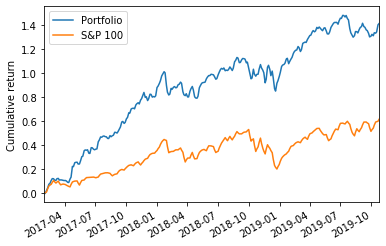

In [26]:
# Run portfolio and see performance visually:
df_portf = backtest_strategy(df_panel, df_mkt, prob_quantile = 0.8)

ax = df_portf.plot(x = "date", y = ['portf_cumret', 'mkt_cumret'])
ax.set_ylabel("Cumulative return")
ax.set_xlabel("")
ax.legend(["Portfolio", "S&P 100"])

In [33]:
# Portfolio assessment:
# Assessment:
from sklearn.linear_model import LinearRegression

df_portf = df_portf.fillna(0)
portf_Y = df_portf['portf_ret']
portf_X = df_portf['mkt_ret']

reg_p = LinearRegression().fit(portf_X.values.reshape(-1, 1), portf_Y.values.reshape(-1, 1))

df_perf1 = pd.DataFrame( columns = ['Portfolio', 'Market'], 
                       index = ['return', 'st dev', 'sharpe', 'alpha', 'beta'])

df_perf1.loc['return', 'Portfolio'] = "{:.4f}".format(df_portf['portf_ret'].mean()*51)
df_perf1.loc['st dev', 'Portfolio'] = "{:.4f}".format(df_portf['portf_ret'].std()*(51**0.5))
df_perf1.loc['sharpe', 'Portfolio'] = "{:.4f}".format((df_portf['portf_ret'].mean()*51 - .02)/(df_portf['portf_ret'].std()*(51**0.5)))
df_perf1.loc['alpha', 'Portfolio'] = "{:.4f}".format(reg_p.intercept_[0]*51)
df_perf1.loc['beta', 'Portfolio'] = "{:.4f}".format(reg_p.coef_[0][0])

df_perf1.loc['return', 'Market'] = "{:.4f}".format(df_portf['mkt_ret'].mean()*51)
df_perf1.loc['st dev', 'Market'] = "{:.4f}".format(df_portf['mkt_ret'].std()*(51**0.5))
df_perf1.loc['sharpe', 'Market'] = "{:.4f}".format((df_portf['mkt_ret'].mean()*51 - .02)/ (df_portf['mkt_ret'].std()*(51**0.5)))
df_perf1.loc['alpha', 'Market'] = "{:.4f}".format(0)
df_perf1.loc['beta', 'Market'] = "{:.4f}".format(1)

print("Comment: \n\n", "The model is helpful as it produced return that is higher than that of the stock market. \n", 
      "Moreover, risk-adjusted return (Alpha) is 15.34% on annualized basis. \n", 
     "Also, Sharpe ratio (reward-to-variability ratio) is almost twice higher for the suggested strategy")

df_perf1


Comment: 

 The model is helpful as it produced return that is higher than that of the stock market. 
 Moreover, risk-adjusted return (Alpha) is 15.34% on annualized basis. 
 Also, Sharpe ratio (reward-to-variability ratio) is almost twice higher for the suggested strategy


,Portfolio,Market
return,0.2521,0.1099
st dev,0.1891,0.1205
sharpe,1.2275,0.7463
alpha,0.1534,0.0000
beta,0.8978,1.0000
